# Identify buildings in images

The idea is that we can combine image locations / FOV with building footprints to deduce where the buildings are in the image, and as such to link them to other metadata such as building ID. 

We assume 'infinitely tall' buildings such that we can work in 2D only. Let's start with some panoramic images and a small segment of Amsterdam buildings.

In [ ]:
# # Extract small subset
# from streetscapes.streetview import SVWorkspace
# ws = SVWorkspace("amsterdam")
# metadata = ws.load_metadata('subset_lcz_kittner_081.parquet')
# sample = metadata.cx[4.900824:4.910663, 52.369162:52.372510].query('`creator.username` == "amsterdam"')[['id', 'compass_angle', 'geometry']]
# sample.to_file('municipality.gpkg', driver='GPKG')

# buildings sample is exported from QGIS, get from Bianca.

In [3]:
import geopandas as gpd

buildings = gpd.read_file('../../testsample.gpkg')
photos = gpd.read_file('../../municipality.gpkg').to_crs(buildings.crs).set_index('id')

<Axes: >

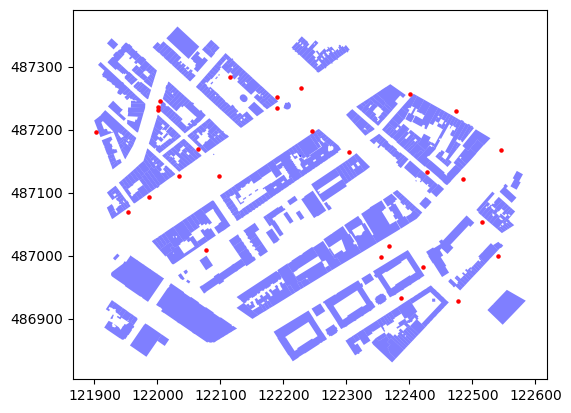

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
buildings.plot(ax=ax, color='blue', alpha=0.5)
photos.plot(ax=ax, color='red', markersize=5)

## Simplify geometry

we can use oriented envelope or minimum rotated rectangle

Or try to use unary_union to condense multipolygon into single polygon

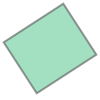

In [5]:
# Get a rectangle outline for the building
buildings.loc[538].geometry.oriented_envelope
buildings.loc[538].geometry.minimum_rotated_rectangle  # same thing

Polygon         577
MultiPolygon      3
Name: count, dtype: int64


<Axes: >

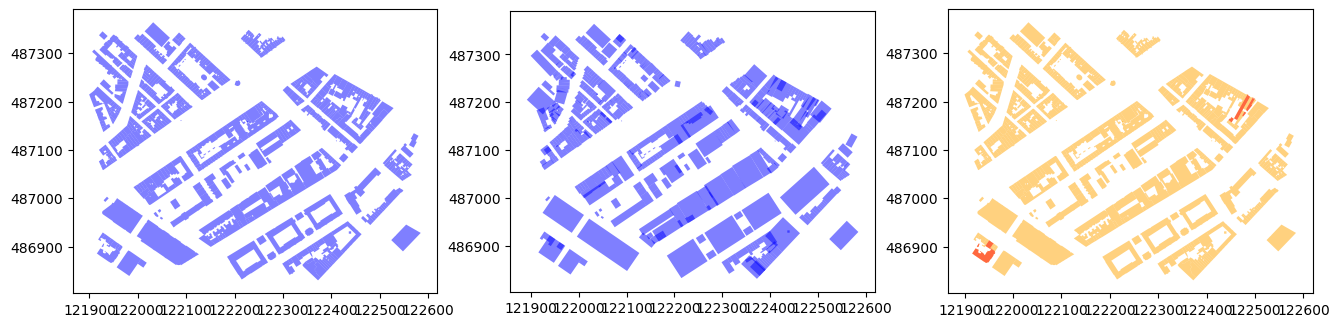

In [6]:
from shapely.ops import unary_union


fig, axs = plt.subplots(1, 3, figsize=(16, 6))

envelopes = buildings.geometry.map(lambda geom: geom.minimum_rotated_rectangle)
unioned = buildings.geometry.map(lambda geom: unary_union(geom))

# Original
buildings.plot(ax=axs[0], color='blue', alpha=0.5)

# Square envelopes
buildings.assign(geometry=envelopes).plot(ax=axs[1], color='blue', alpha=0.5)

# Simplified polygons
buildings.assign(geometry=unioned).plot(ax=axs[2], color='orange', alpha=0.5)

# Check if all multipolygons are condensed into single polygons
# Disjoint polygons can't be merged into a single polygon
print(unioned.geom_type.value_counts())
buildings.assign(geom_type = unioned.geom_type).query('geom_type == "MultiPolygon"').plot(ax=axs[2], color='red', alpha=0.5)

In [7]:
# let's continue with the simplified polygons and split the disjoint ones:
buildings = buildings.assign(geometry=unioned).explode()  # explode splits multipolygons into multiple rows with single polygons while keeping the index

## Get field of view of the images

In [8]:
def get_image_field_of_view(photos, buffer_distance=50):
    """
    Get the field of view for each photo by creating a buffer around the geometry.

    TODO: could extent this to create a wedge shape for panoramic images.
    """
    return photos.assign(geometry=photos.geometry.buffer(buffer_distance))

<Axes: >

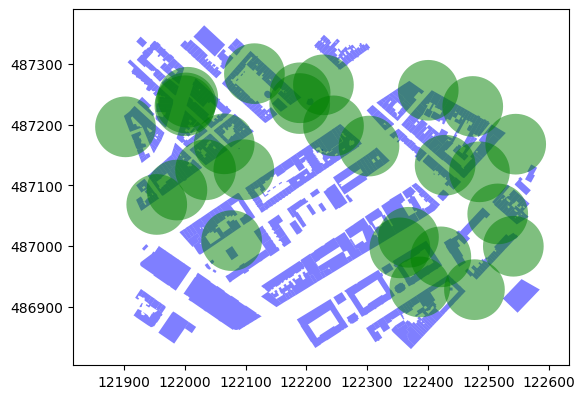

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# All buildings and photos
buildings.plot(ax=ax, color='blue', alpha=0.5)
photos.assign(geometry = photos.geometry.buffer(50)).plot(ax=ax, color='green', alpha=0.5)

# Sort buildings by distance to the photo

In [10]:
photo = photos.loc[['1728589477321224']]
distance = buildings.geometry.map(lambda geom: geom.distance(photo.geometry).item())
buildings.assign(distance=distance).sort_values(by='distance').head(5)

,identificatie,b3_h_50p_awmean,b3_h_max,b3_h_min,b3_h_maaiveld,b3_opp_grond,b3_volume_lod22,oorspronkelijkbouwjaar,layer,path,real_b3_h_50p_awmean,building_period,HERITAGE-class,geometry,distance
564,NL.IMBAG.Pand.0363100012170566,17.073169,26.523645,3.613176,0.191,58312.500000,9.775944e+05,2000.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,16.882169,1992-2005,7,"POLYGON ((122340.508 487038, 122333.828 487049...",14.811335
565,NL.IMBAG.Pand.0363100012170563,19.165152,26.991854,8.468910,1.841,108647.000000,1.196575e+06,1998.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,17.324152,1992-2005,7,"POLYGON ((122369.242 486933.563, 122363.227 48...",20.004438
562,NL.IMBAG.Pand.0363100012165617,16.790738,26.239664,3.556516,1.456,20147.820068,2.568368e+05,2000.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,15.334738,1992-2005,7,"POLYGON ((122304.664 487036.032, 122296.414 48...",20.489985
156,NL.IMBAG.Pand.0363100012248781,14.221854,25.591179,4.841933,0.154,6915.329956,9.601889e+04,2020.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,14.067854,>=2015,9,"POLYGON ((122385.266 487045, 122379.258 487054...",33.633536
155,NL.IMBAG.Pand.0363100012246221,19.084473,26.694761,5.866517,1.015,28240.380615,5.088069e+05,2017.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,18.069473,>=2015,9,"POLYGON ((122278.398 486999.719, 122281.016 48...",45.461169


### Select a few buildings and one image + get intersection

but keep as geodataframe

<Axes: >

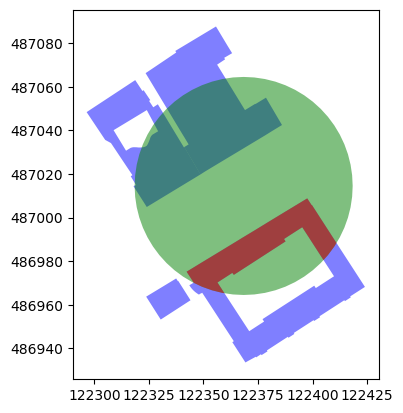

In [11]:
# Selected buildings and photo
buildings = buildings.loc[[565, 562, 564, 560]]
fov = photo.geometry.buffer(50)

fig, ax = plt.subplots()
buildings.plot(ax=ax, color='blue', alpha=0.5)
fov.plot(ax=ax, color='green', alpha=0.5)

intersection = buildings.loc[565].geometry.intersection(photo.geometry.buffer(50))
intersection.plot(ax=ax, color='red', alpha=0.5)

## Try 'radial sweep' algorithm the get visibility 

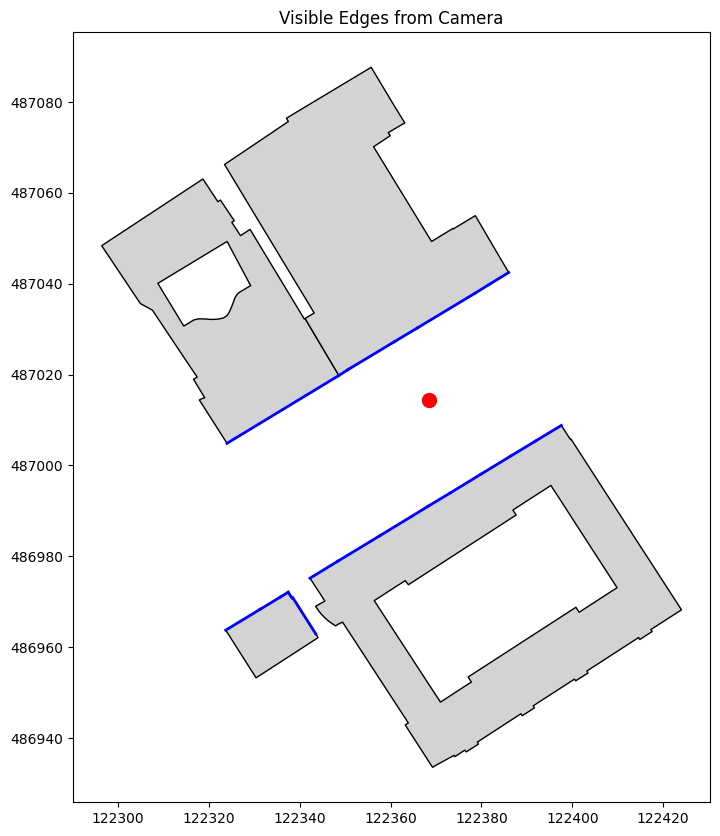

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Camera parameters
fov_center_deg = 0.0
fov_width_deg = 360.0
max_range = 80

# Camera location (Shapely point)
camera_point = photo.geometry.iloc[0]

# Convert building polygons to a list of edges
edges = []
for poly in buildings.geometry:
    exterior_coords = list(poly.exterior.coords)
    n = len(exterior_coords)
    for i in range(n - 1):  # ignore closing segment because coords repeat first point
        edges.append(LineString([exterior_coords[i], exterior_coords[i+1]]))

# Function to cast a ray and find nearest intersection
def cast_ray(origin, angle_deg, edges, max_range):
    dx = np.cos(np.radians(angle_deg)) * max_range
    dy = np.sin(np.radians(angle_deg)) * max_range
    ray = LineString([origin, (origin.x + dx, origin.y + dy)])
    
    min_dist = max_range
    nearest_edge = None
    
    for edge in edges:
        inter = ray.intersection(edge)
        if not inter.is_empty:
            # Could be a Point or MultiPoint
            pts = [inter] if inter.geom_type == 'Point' else list(inter.geoms)
            for pt in pts:
                dist = origin.distance(pt)
                if dist < min_dist:
                    min_dist = dist
                    nearest_edge = edge
    return nearest_edge

# Sweep through angles and collect visible edges
angles = np.linspace(fov_center_deg - fov_width_deg/2,
                     fov_center_deg + fov_width_deg/2, 360)
visible_edges = set()

for angle in angles:
    edge = cast_ray(camera_point, angle, edges, max_range)
    if edge:
        visible_edges.add(edge)

# Plot
fig, ax = plt.subplots(figsize=(10,10))
buildings.plot(ax=ax, color='lightgray', edgecolor='black')

for edge in visible_edges:
    x, y = edge.xy
    ax.plot(x, y, color='blue', linewidth=2)

photo.plot(ax=ax, color='red', marker='o', markersize=100)
ax.set_title("Visible Edges from Camera")
plt.show()


Notice that this doesn't properly account for occlusion: the full edge is highlighted if even a small segment of it is 'hit' by a ray. The version below does a better job:

/scratch-local/69026/ipykernel_3702384/2842324315.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cam = Point(photo.geometry.x[0], photo.geometry.y[0])
/scratch-local/69026/ipykernel_3702384/2842324315.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


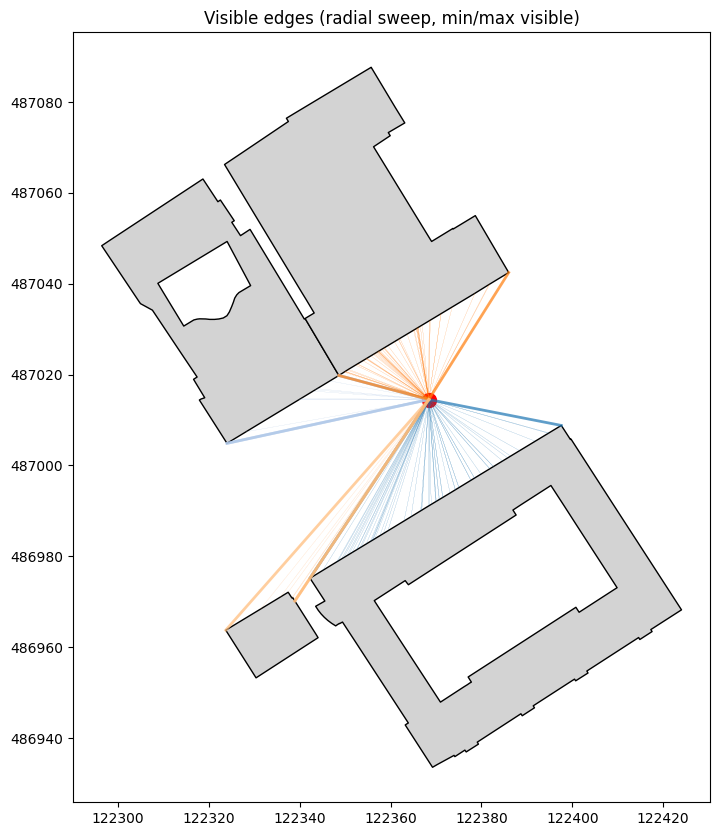

   building_idx                   identificatie  min_angle_deg  max_angle_deg
0             0  NL.IMBAG.Pand.0363100012170563     236.377149     348.932786
1             1  NL.IMBAG.Pand.0363100012165617     165.023698     192.245671
2             2  NL.IMBAG.Pand.0363100012170566      57.819200     165.023698
3             3  NL.IMBAG.Pand.0363100012182649     228.636448     236.377149


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from matplotlib.cm import get_cmap
from matplotlib.colors import to_rgba
import pandas as pd
import numpy as np

cam = Point(photo.geometry.x[0], photo.geometry.y[0])
max_range = 80

# Prepare building edges
edges = []
building_polygons = list(buildings.geometry)
edge_to_building = []
for b_idx, poly in enumerate(building_polygons):
    coords = list(poly.exterior.coords)
    for i in range(len(coords)-1):
        seg = LineString([coords[i], coords[i+1]])
        edges.append(seg)
        edge_to_building.append(b_idx)

# Collect all vertices for angle candidates
vertices = [pt for seg in edges for pt in seg.coords]
angles = np.arctan2(
    np.array([y - cam.y for x, y in vertices]),
    np.array([x - cam.x for x, y in vertices])
)
angles = np.unique(np.concatenate([angles - 1e-8, angles, angles + 1e-8]))
angles = np.mod(angles, 2*np.pi)  # normalize to 0..2pi

def ray_line_intersect(p0, p1, ray_origin, ray_dir):
    x1, y1 = p0
    x2, y2 = p1
    x3, y3 = ray_origin
    dx, dy = ray_dir
    det = (x2 - x1)*(-dy) - (y2 - y1)*(-dx)
    if abs(det) < 1e-8:
        return None
    t = ((x3 - x1)*(-dy) - (y3 - y1)*(-dx))/det
    u = -((x2 - x1)*(y1 - y3) - (y2 - y1)*(x1 - x3))/det
    if 0 <= t <= 1 and u >= 0:
        return (x1 + t*(x2 - x1), y1 + t*(y2 - y1))
    return None

# Prepare data structure: store rays + min/max angle per building
building_data = {}
for b_idx in range(len(building_polygons)):
    building_data[b_idx] = {"rays": [], "min_angle": None, "max_angle": None}

# Sweep through angles and find nearest hit per angle
for angle in angles:
    ray_dir = (np.cos(angle), np.sin(angle))
    min_dist2 = max_range**2
    nearest_pt = None
    nearest_building = None

    for edge, b_idx in zip(edges, edge_to_building):
        pt = ray_line_intersect(edge.coords[0], edge.coords[1], (cam.x, cam.y), ray_dir)
        if pt:
            dx = pt[0] - cam.x
            dy = pt[1] - cam.y
            dist2 = dx*dx + dy*dy
            if dist2 < min_dist2:
                min_dist2 = dist2
                nearest_pt = pt
                nearest_building = b_idx

    if nearest_building is not None:
        data = building_data[nearest_building]
        data["rays"].append((angle, nearest_pt))
        # Update min/max visible angle
        if (data["min_angle"] is None) or (angle < data["min_angle"]):
            data["min_angle"] = angle
        if (data["max_angle"] is None) or (angle > data["max_angle"]):
            data["max_angle"] = angle

# Plot with min/max highlighted
fig, ax = plt.subplots(figsize=(10,10))
buildings.plot(ax=ax, color='lightgray', edgecolor='black')

cmap = get_cmap("tab20")
for b_idx, data in building_data.items():
    if not data["rays"]:
        continue
    color = to_rgba(cmap(b_idx % 20), alpha=0.7)
    
    # all rays lightly
    for a, pt in data["rays"]:
        ax.plot([cam.x, pt[0]], [cam.y, pt[1]], color=color, linewidth=0.05)
    
    # highlight min/max rays
    for a, pt in data["rays"]:
        if np.isclose(a, data["min_angle"]) or np.isclose(a, data["max_angle"]):
            ax.plot([cam.x, pt[0]], [cam.y, pt[1]], color=color, linewidth=2)

photo.plot(ax=ax, color='red', marker='o', markersize=100)
ax.set_title("Visible edges (radial sweep, min/max visible)")
plt.show()

# Build a quick table
angle_table = []
for b_idx, data in building_data.items():
    angle_table.append({
        "building_idx": b_idx,
        "identificatie": buildings.iloc[b_idx]['identificatie'],
        "min_angle_deg": np.degrees(data["min_angle"]) if data["min_angle"] is not None else None,
        "max_angle_deg": np.degrees(data["max_angle"]) if data["max_angle"] is not None else None
    })

angle_df = pd.DataFrame(angle_table)
print(angle_df)


## Now let's see if these angles make sense

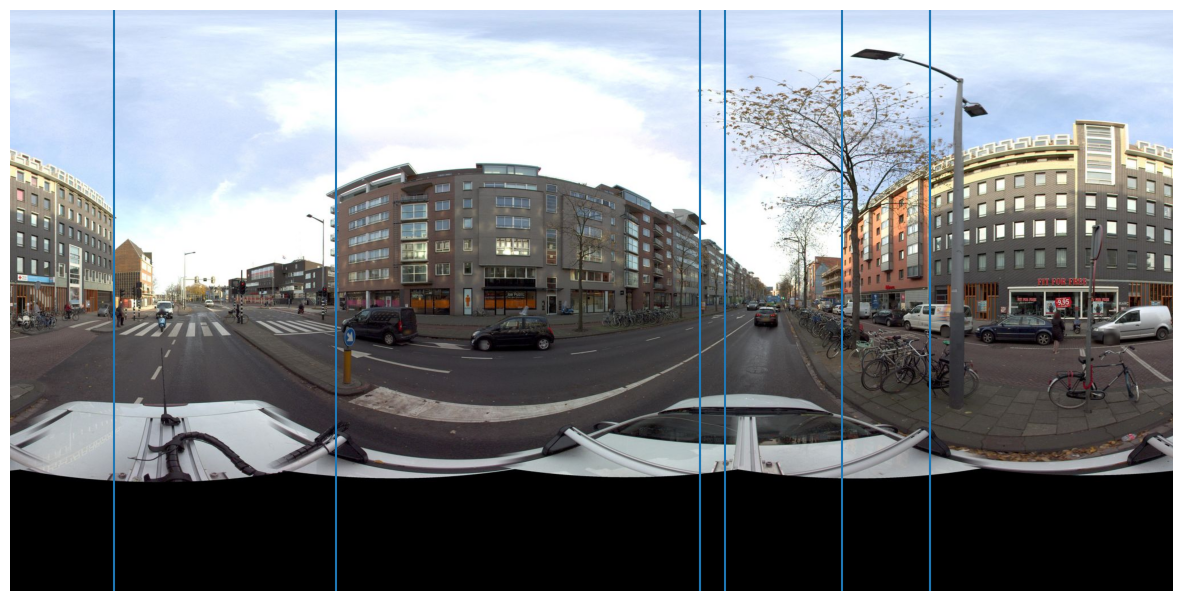

In [36]:
from PIL import Image
from streetscapes.streetview.workspace import get_image_dir
imdir = get_image_dir('mapillary')
image = Image.open(imdir / f"{photo.index[0]}.jpeg")

image_array = np.array(image)
image_array.shape

# We want 0 degrees to be the first pixel, currently 'compass_angle = 0' means
# it is exactly in the middle, so roll it back.
image_rolled = np.roll(image_array, -1024, axis=1)


def angle_to_pixel(angle, image_width=2048):
    return int(image_width / 360 * angle)

def compass_angle(angle_deg):
    compass_deg = (90 - angle_deg) % 360
    return compass_deg

fig, ax =  plt.subplots(figsize=(15, 15))
ax.imshow(image_rolled)
plt.axis('off')

for i, building in angle_df.iterrows():
    plt.axvline(angle_to_pixel(compass_angle(building.min_angle_deg)))
    plt.axvline(angle_to_pixel(compass_angle(building.max_angle_deg)))